In [1]:
%matplotlib inline
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt

First, here's the SPA power function:

In [2]:
def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)


Here are two helper functions for computing the dot product over space, and for plotting the results

In [14]:
def spatial_dot(v, X, Y, xs, ys, transform=1):
    if isinstance(v, spa.SemanticPointer):
        v = v.v
    vs = np.zeros((len(ys),len(xs)))
    for i,x in enumerate(xs):
        for j, y in enumerate(ys):
            t = power(X, x)*power(Y,y)*transform
            vs[j,i] = np.dot(v, t.v)
    return vs

def spatial_plot(vs, colorbar=True, vmin=-1, vmax=1, cmap='plasma'):
    vs = vs[::-1, :]
    plt.imshow(vs, interpolation='none', extent=(xs[0],xs[-1],ys[0],ys[-1]), vmax=vmax, vmin=vmin, cmap=cmap)
    if colorbar:
        plt.colorbar()
        

Let's do a quick example of using the above functions to represent two items at (2,1.3) and (0,0.7)

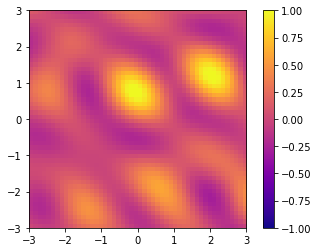

In [4]:
D = 64
X = spa.SemanticPointer(D)
X.make_unitary()
Y = spa.SemanticPointer(D)
Y.make_unitary()
xs = np.linspace(-3, 3, 50)
ys = np.linspace(-3, 3, 50)


v = power(X,2)*power(Y,1.3) + power(X,0)*power(Y,0.7)
vs = spatial_dot(v, X, Y, xs, ys)
spatial_plot(vs)

So, that lets us take a vector and turn it into a spatial map.  Now let's try going the other way around: specify a desired map, and find the vector that gives that.

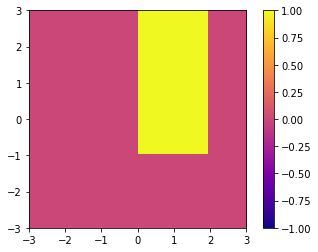

In [5]:
desired = np.zeros((len(xs),len(ys)))
for i,x in enumerate(xs):
    for j, y in enumerate(ys):
        if 0<x<2 and -1<y<=3:
            val = 1
        else:
            val = 0
        desired[j, i] = val
        
spatial_plot(desired)


This can be treated as a least-sqares minimization problem.  In paticular, we're trying to build the above map using a basis space.  The basis vectors in that space are *the spatial maps of the D unit vectors in our vector space*!!  So let's compute those, and use our standard nengo solver:

In [6]:
A = np.array([spatial_dot(np.eye(D)[i], X, Y, xs, ys).flatten() for i in range(D)])

In [7]:
import nengo
v, info = nengo.solvers.LstsqL2(reg=0)(np.array(A).T, desired.flatten())

0.16786085681023427


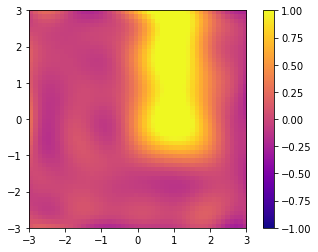

In [8]:
vs = spatial_dot(v, X, Y, xs, ys)
rmse = np.sqrt(np.mean((vs-desired)**2))
print(rmse)
spatial_plot(vs)

Yay!

However, one possible problem with this approach is that the norm of this vector is unconstrained:

In [9]:
np.linalg.norm(v)

47.55941477447978

A better solution would add a constraint on the norm.  For that, we use cvxpy

In [10]:
import cvxpy as cvx

class CVXSolver(nengo.solvers.Solver):
    def __init__(self, norm_limit):
        super(CVXSolver, self).__init__(weights=False)
        self.norm_limit = norm_limit

    def __call__(self, A, Y, rng=np.random, E=None):
        N = A.shape[1]
        D = Y.shape[1]

        d = cvx.Variable((N, D))
        error = cvx.sum_squares(A * d - Y)

        cvx_prob = cvx.Problem(cvx.Minimize(error), [cvx.norm(d) <= self.norm_limit])
        cvx_prob.solve()
        decoder = d.value
        rmses = np.sqrt(np.mean((Y-np.dot(A, decoder))**2, axis=0))

        return decoder, dict(rmses=rmses)

In [11]:
v2, info2 = CVXSolver(norm_limit=10)(np.array(A).T, desired.flatten().reshape(-1,1))
v2.shape = D,

c:\users\terry\py3\lib\site-packages\cvxpy\problems\problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:


rmse: 0.17484126538441508
norm: 10.000000009902635


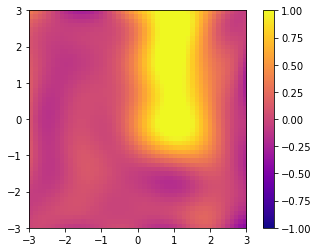

In [12]:
vs2 = spatial_dot(v2, X, Y, xs, ys)
rmse2 = np.sqrt(np.mean((vs2-desired)**2))
print('rmse:', rmse2)
spatial_plot(vs2)
print('norm:', np.linalg.norm(v2))

Looks like the accuracy depends on what limit we put on the norm.  Let's see how that varies:

c:\users\terry\py3\lib\site-packages\cvxpy\problems\problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:


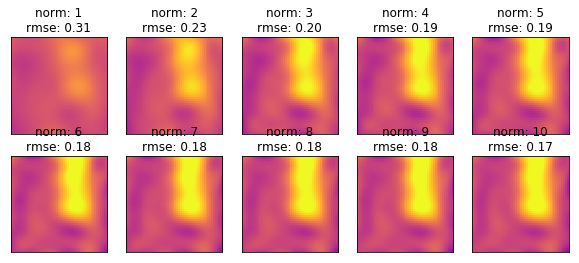

In [13]:
plt.figure(figsize=(10,4))
limits = np.arange(10)+1
for i, limit in enumerate(limits):
    plt.subplot(2, 5, i+1)
    vv, _ = CVXSolver(norm_limit=limit)(np.array(A).T, desired.flatten().reshape(-1,1))
    
    s = spatial_dot(vv.flatten(), X, Y, xs, ys)
    error = np.sqrt(np.mean((s-desired)**2))
    spatial_plot(s, colorbar=False)
    plt.title('norm: %g\nrmse: %1.2f' % (limit, error))
    plt.xticks([])
    plt.yticks([])


Looks like it works fine with norms that aren't too large.

As Aaron pointed out, we can also look at this basis space:

c:\users\terry\py3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


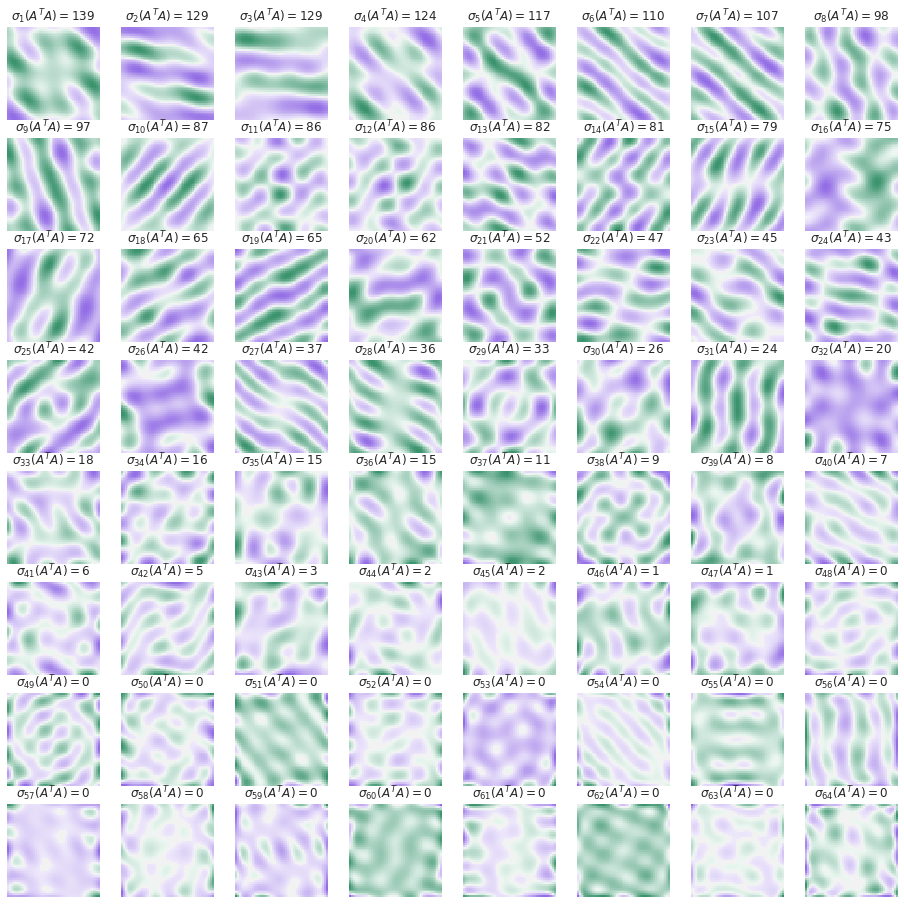

In [16]:
import seaborn

SA = np.array(A).T  # A matrix passed to solver
gamma = SA.T.dot(SA)
U, S, V = np.linalg.svd(gamma)
w = int(np.sqrt(D))
h = int(np.ceil(D // w))

plt.figure(figsize=(16, 16))
for i in range(len(U)):
    # the columns of U are the left-singular vectors
    vs = spatial_dot(U[:, i], X, Y, xs, ys)
    plt.subplot(w, h, i+1)
    spatial_plot(vs, colorbar=False, vmin=None, vmax=None, cmap=seaborn.diverging_palette(150, 275, s=80, l=55, as_cmap=True))
    plt.title(r"$\sigma_{%d}(A^T A) = %d$" % (i+1, S[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()